## Visualizations with Py-ART

First we'll import needed packages

In [1]:
import pyart
from matplotlib import pyplot as plt
import numpy as np
import os
import s3fs
from datetime import datetime as dt

%matplotlib inline
print(pyart.__version__)

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
#warnings.simplefilter('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

1.8.0


In [2]:
def get_latest_file(radar_id, bucket='noaa-nexrad-level2', engine='s3fs'):
    """Return latest NEXRAD data file name."""
    s3conn = s3fs.S3FileSystem(anon=True)
    latest_year = os.path.join(
        bucket, os.path.basename(s3conn.ls(bucket)[-1]))
    latest_month = os.path.join(
        latest_year, os.path.basename(s3conn.ls(latest_year)[-1]))
    latest_day = os.path.join(
        latest_month, os.path.basename(s3conn.ls(latest_month)[-1]))
    return s3conn.ls(os.path.join(latest_day, radar_id))[-1]

### Py-ART Colormaps
Retrieve the names of colormaps and the colormap list dictionary.

The colormaps are registered with matplotlib and can be accessed by inserting `'pyart_'` in front of any name.

In [3]:
cm_names = pyart.graph.cm._cmapnames
cms = pyart.graph.cm.cmap_d

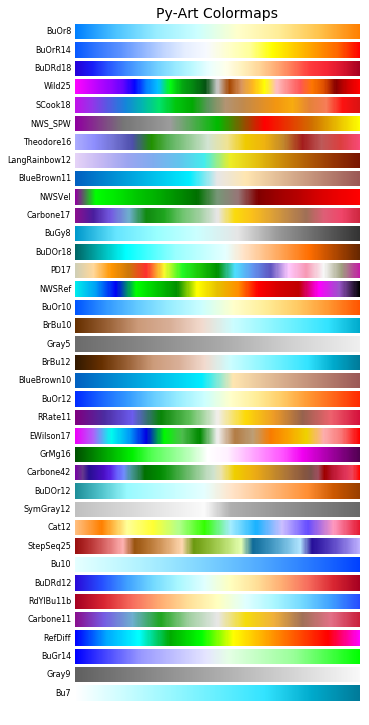

In [4]:
nrows = len(cm_names)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Create a figure and axes instance
fig, axes = plt.subplots(nrows=nrows, figsize=(5,10))
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
axes[0].set_title('Py-Art Colormaps', fontsize=14)

# Loop through the possibilities
for nn, pymap in enumerate(cm_names):
    axes[nn].imshow(gradient, aspect='auto', cmap=cms[pymap])
    pos = list(axes[nn].get_position().bounds)
    x_text = pos[0] - 0.01
    y_text = pos[1] + pos[3]/2.
    fig.text(x_text, y_text, pymap, va='center', ha='right', fontsize=8)

# Turn off *all* ticks & spines, not just the ones with colormaps.
for ax in axes:
    ax.set_axis_off()

### The RadarDisplay
This is the most commonly used class designed for surface-based scanning radar

In [ ]:
### Plot a NEXRAD file

In [12]:
nexf = "data/KILN20140429_231254_V06"
nexr = pyart.io.read(nexf)
nexd = pyart.graph.RadarDisplay(nexr)

In [17]:
nexr.fields.keys()

dict_keys(['differential_reflectivity', 'differential_phase', 'velocity', 'spectrum_width', 'cross_correlation_ratio', 'reflectivity'])

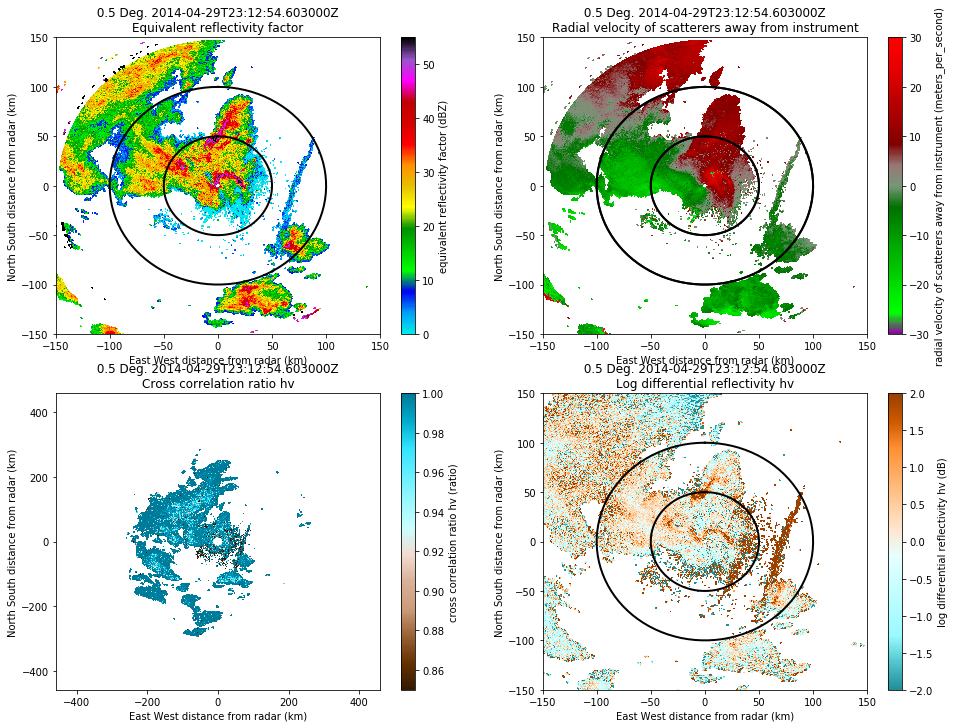

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
nexd.plot('reflectivity', sweep=1, cmap='pyart_NWSRef', vmin=0., vmax=55., mask_outside=False, ax=ax[0, 0])
nexd.plot_range_rings([50, 100], ax=ax[0, 0])
nexd.set_limits((-150., 150.), (-150., 150.), ax=ax[0, 0])

nexd.plot('velocity', sweep=1, cmap='pyart_NWSVel', vmin=-30, vmax=30., mask_outside=False, ax=ax[0, 1])
nexd.plot_range_rings([50, 100], ax=ax[0, 1])
nexd.set_limits((-150., 150.), (-150., 150.), ax=ax[0, 1])

nexd.plot('cross_correlation_ratio', sweep=0, cmap='pyart_BrBu12', vmin=0.85, vmax=1., mask_outside=False, ax=ax[1, 0])
nexd.plot_range_rings([50, 100], ax=ax[0, 1])
nexd.set_limits((-150., 150.), (-150., 150.), ax=ax[0, 1])

nexd.plot('differential_reflectivity', sweep=0, cmap='pyart_BuDOr12', vmin=-2, vmax=2., mask_outside=False, ax=ax[1, 1])
nexd.plot_range_rings([50, 100], ax=ax[1, 1])
nexd.set_limits((-150., 150.), (-150., 150.), ax=ax[1, 1])

#### There are many keyword values we can employe to refine the plot
Keywords exist for title, labels, colorbar, along with others.
In addition, there are many methods that can be employed. For example, pull out a constructed RHI at a given azimuth.

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/pyart/core/transforms.py:205: RuntimeWarning: invalid value encountered in arccos
  full_angle_rad = np.arccos(dot_product)
/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/pyart/core/transforms.py:185: RuntimeWarning: invalid value encountered in less
  edges[edges < 0] += 360     # range from [-180, 180] to [0, 360]
/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/pyart/graph/radardisplay.py:727: RuntimeWarning: invalid value encountered in less
  reverse_xaxis = np.all(R < 1.)


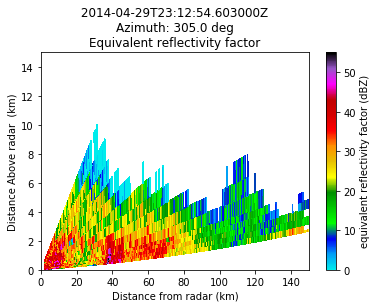

In [49]:
nexd.plot_azimuth_to_rhi('reflectivity', 305., cmap='pyart_NWSRef', vmin=0., vmax=55.)
nexd.set_limits((0., 150.), (0., 15.))

### Py-ART RHI
Not only can we construct an RHI from a PPI volume, but RHI scans may be plotted as well.

In [63]:
rhif = "data/KILN20140429_231254_V06"
rhir = pyart.io.read(rhif)
rhid = pyart.graph.RadarDisplay(rhir)

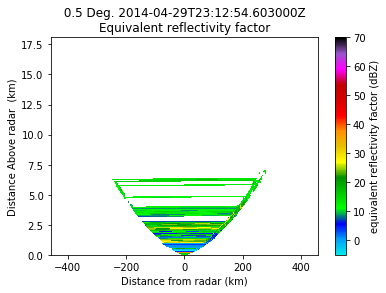

In [65]:
rhid.plot_rhi('reflectivity', 0, vmin=-5.0, vmax=70,)

### Py-ART RadarMapDisplay or RadarMapDisplayCartopy
This converts the x-y coordinates to latitude and longitude overplotting on a map

In [51]:
nexmap = pyart.graph.RadarMapDisplayCartopy(nexr)

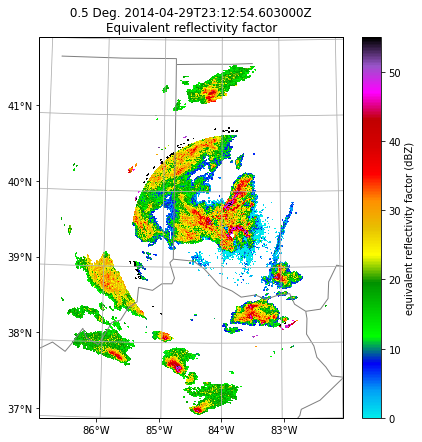

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
nexmap.plot_ppi_map('reflectivity', sweep=1, vmin=0., vmax=55., ax=ax)
nexmap.ax.set_extent([-87., -82., 37., 42.])

## Py-ART Airborne Plotting Class
This class can plot a horizontal surveillance scan (also known as a lower fuselage scan) and is treated like a typical ground radar scan with only a single elevation.

Additionally, a scanning tail radar file may be plotted. We'll test this below using a file from the G-IV.

In [10]:
#rg4 = pyart.io.read("data/g4_tdr_140527201314.RAWFW3C")
rg4 = pyart.io.read_sigmet("data/3TA150205230714.RAWLGHM")
dg4 = pyart.graph.RadarDisplay_Airborne(rg4)

TypeError: 'float' object cannot be interpreted as an integer

In [6]:
dg4.plot('reflectivity', cmap=pyart.graph.cm.NWSRef)
dg4.set_limits(xlim=(-20, 20), ylim=(-5, 10))

FileNotFoundError: [Errno 2] No such file or directory: '/data/g4/tdr/nrm140527201314.RAWFW3C'